In [ ]:
import sys
import pickle
 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
from numpy import std
from numpy import mean
from joblib import dump
from fbprophet import Prophet
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing,metrics,model_selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,mean_squared_error,mean_squared_error, r2_score, mean_absolute_error
 
#set seaborn style
sns.set(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Import the data into a dataframe called data through github link. 
#Set low memory to false because the dataset is large.
 
url_sample_submission = 'https://raw.githubusercontent.com/mwi-kali/Data/master/sample_submission.csv'
url_store = 'https://raw.githubusercontent.com/mwi-kali/Data/master/store.csv'
url_test = 'https://raw.githubusercontent.com/mwi-kali/Data/master/test.csv'
url_train = 'https://raw.githubusercontent.com/mwi-kali/Data/master/train.csv'
 
data_sample_submission = pd.read_csv(url_sample_submission, low_memory = False)
data_store = pd.read_csv(url_store, low_memory = False)
data_test = pd.read_csv(url_test, low_memory = False)
data_train = pd.read_csv(url_train, low_memory = False)

# **Data preprocessing**

It is important to process the data into a format where it can be fed to a machine learning model. This typically means converting all non-numeric columns to numeric, handling NaN values and generating new features from already existing features. 

The use of a KNN model to predict or fill missing values is referred to as “Nearest Neighbor Imputation” or “KNN imputation.”

In [ ]:
#fill in missing values with KNN approach
imputer = KNNImputer(weights="uniform")
data_store.iloc[:,3:-1] = imputer.fit_transform(data_store.iloc[:,3:-1])

#fill in missing values with mean 
data_test = data_test.fillna(data_test.mean())

In [ ]:
def date_range(data):
  dates = pd.to_datetime(data['Date']).sort_values()
  dates = dates.unique()
  start_date = dates[0]
  end_date = dates[-1]
  print("Start date: ", start_date)
  print("End Date: ", end_date)
  date_range = pd.date_range(start_date, end_date).values

In [ ]:
datasets = [data_test , data_train]

In [ ]:
for data in datasets:
  date_range(data)

Start date:  2015-08-01T00:00:00.000000000
End Date:  2015-09-17T00:00:00.000000000
Start date:  2013-01-01T00:00:00.000000000
End Date:  2015-07-31T00:00:00.000000000


In [ ]:
for data in datasets:
  all_columns = list(data.iloc[:,2:].columns)
  for x in all_columns:
    if x != 'Date':
      try:
          data[x] = np.where(data[x] > data[x].quantile(0.95), data[x].quantile(0.50), data[x])
      except TypeError:
          continue

In [ ]:
#remove no sales
not_open = data_train[(data_train['Open'] == 0) & (data_train['Sales'] != 0)]
print("No closed store with sales: " + str(not_open.size == 0))
data_train = data_train.loc[data_train['Sales'] > 0]

No closed store with sales: True


In [ ]:
datasets = [data_test , data_train]

In [ ]:
for data in datasets:
  data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data_train['SalesPerCustomer'] = data_train['Sales'] / data_train['Customers']
avg_store = data_train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
data_store = pd.merge(avg_store.reset_index(), data_store, on='Store',suffixes=(False, False))

### **Changing features data type**

In [ ]:
class features:
  def __init__(self):
    print ("Features object created")
  def string_to_int(self,store,train):
    store.loc[:,'StoreType'] = store.loc[:,'StoreType'].astype('category').cat.codes
    store.loc[:,'Assortment'] = store.loc[:,'Assortment'].astype('category').cat.codes
    train.loc[:,"StateHoliday"] = train.loc[:,"StateHoliday"].astype('category').cat.codes
    merged = pd.merge(train, store, on='Store', how='left')
    return merged
  def remove_nan(self,merged):
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)
    merged['Year'] = merged.Date.dt.year
    merged['Month'] = merged.Date.dt.month
    merged['Day'] = merged.Date.dt.day
    merged['Week'] = merged.Date.dt.week
    return merged
  def month_competetions(self,merged):
    # Number of months that competition has existed for
    NaN_replace = 0
    merged['MonthsCompetitionOpen'] = 12 * (merged.loc[:,'Year'] - merged.loc[:,'CompetitionOpenSinceYear']) + \
    (merged.loc[:,'Month'] - merged.loc[:,'CompetitionOpenSinceMonth'])
    merged.loc[merged['CompetitionOpenSinceYear'] == NaN_replace, 'MonthsCompetitionOpen'] = NaN_replace
    return merged
  def weeks_promo_open(self,merged):
    # Number of weeks that promotion has existed for
    NaN_replace = 0
    merged['WeeksPromoOpen'] = 12 * (merged['Year'] - merged['Promo2SinceYear']) + \
    (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
    merged.loc[merged['Promo2SinceYear'] == NaN_replace, 'WeeksPromoOpen'] = NaN_replace
    return merged
  def to_int(self,merged):
    toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 
        'Promo2SinceYear', 
        'MonthsCompetitionOpen', 
        'WeeksPromoOpen'
    ]
    merged[toInt] = merged[toInt].astype(int)
    return merged
  def add_mean(self,train,store):
    med_store = train.groupby('Store')[['Sales', 'Customers','SalesPerCustomer']].mean()
    med_store.rename(columns=lambda x: 'Med' + x, inplace=True)
    store = pd.merge(med_store.reset_index(), store, on='Store',suffixes=(False, False))
    return store

In [ ]:
feature_selection = features()

Features object created


In [ ]:
data_store = feature_selection.add_mean(data_train,data_store)

In [ ]:
merge = feature_selection.string_to_int(data_store,data_train)

In [ ]:
merge = feature_selection.remove_nan(merge)

In [ ]:
merge = feature_selection.month_competetions(merge)

In [ ]:
merge = feature_selection.weeks_promo_open(merge)

In [ ]:
merge = feature_selection.to_int(merge)

In [ ]:
merge['CompetitionDistance'] = np.log(merge['CompetitionDistance'] + 1)

### **Scale the data**

This helps with predictions especially when using machine learning algorithms that use Euclidean distances. 

In [ ]:
merged = merge[['Customers','CompetitionDistance','Promo','Promo2','StateHoliday','StoreType','Assortment','AvgSales','AvgCustomers','AvgSalesPerCustomer','MedSales','MedCustomers','MedSalesPerCustomer','DayOfWeek','Week','Day','Month','Year','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']]

In [ ]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(merged)
merged = pd.DataFrame(scaled_df,columns = ['Customers','CompetitionDistance','Promo','Promo2','StateHoliday','StoreType','Assortment','AvgSales','AvgCustomers','AvgSalesPerCustomer','MedSales','MedCustomers','MedSalesPerCustomer','DayOfWeek','Week','Day','Month','Year','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear'])

In [ ]:
merged[['Sales','Store']] = merge[['Sales','Store']]

# **Building models with sklearn pipelines**

In [ ]:
X = merged[['Store','Customers','CompetitionDistance','Promo','Promo2','StateHoliday','StoreType','Assortment','AvgSales','AvgCustomers','AvgSalesPerCustomer','MedSales','MedCustomers','MedSalesPerCustomer','DayOfWeek','Week','Day','Month','Year','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']]
y = merged['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

A reasonable starting point will be to use any of the tree based algorithms. Random forests Regressor will make for a good start. 

MSE criterion is the sum of squared distances between our target variable and predicted values.

In [ ]:
# create regressor object 
regressor = RandomForestRegressor(n_estimators=10,criterion='mse',n_jobs=4) 
  
# fit the regressor with x and y data 
regressor = regressor.fit(X_train,y_train)

In [ ]:
y_pred = regressor.predict(X_test)

(array([  251.,  3443., 15452., 33873., 49195., 39932., 29973., 21374.,
        14492.,  3100.]),
 array([  148.3 ,  1332.21,  2516.12,  3700.03,  4883.94,  6067.85,
         7251.76,  8435.67,  9619.58, 10803.49, 11987.4 ]),
 <a list of 10 Patch objects>)

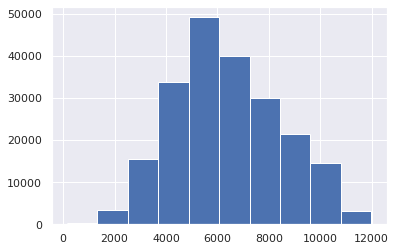

In [ ]:
plt.hist(y_pred)

In [ ]:
print('Mean Absolute Error: %.4f' % metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error: %.4f' % metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: %.4f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 373.3648
Mean Squared Error: 491467.4817
Root Mean Squared Error: 701.0474


In [ ]:
# score on test data (accuracy)
acc = regressor.score(X_test, y_test)
print('Accuracy percent: %.4f' % (acc*100))

Accuracy percent: 89.6155


### **Using Prophet**

Forecast sales in the stores across several cities six weeks ahead of time.

In [ ]:
p_model = Prophet(daily_seasonality=True )
future = data_train[['Date','Sales']]
future = future.rename(columns={'Date':'ds','Sales':'y'})
p_model.fit(future)

# dataframe that extends into future 6 weeks 
future_dates = p_model.make_future_dataframe(periods = 6*7)
forecast = p_model.predict(future_dates)
forecast[['ds', 'y_pred', 'y_pred_lower', 'y_pred_upper']].tail()

In [ ]:
forecast = m.predict(future_dates.head(100,000))

# preditions for last week
forecast.tail(10)#

### **Loss Function**

Loss functions indicate how well our model is performing. 

This means that the loss functions affect the overall output of sales prediction. 

Huber loss is less sensitive to outliers in data than the squared error loss. It’s also differentiable at 0. It’s basically absolute error, which becomes quadratic when error is small. 

It combines the best of Mean Absolute Error and Mean Square Error.

In [ ]:
l_regressor = GradientBoostingRegressor(loss='huber')
l_regressor.fit(X_train, y_train)
l_regressor.predict(X_test)
l_regressor.score(X_test, y_test)

0.8090222389996382

# **Pipeline**

Pipelines makes modeling modular and more reproducible.

In [ ]:
r_pipeline = Pipeline(steps=[('m', regressor)])
r_pipeline.fit(X_train,y_train)
y_pred = r_pipeline.predict(X_test)
r_pipeline.score(X_test, y_test)

0.8960280574589763

In [ ]:
l_pipeline = Pipeline(steps=[('m', l_regressor)])
l_pipeline.fit(X_train,y_train)
y_pred = l_pipeline.predict(X_test)
l_pipeline.score(X_test, y_test)

0.8090222389996382

In [ ]:
p_pipeline = Pipeline(steps=[('m', p_model)])
p_pipeline.fit(X_train,y_train)
y_pred = p_pipeline.predict(X_test)
p_pipeline.score(X_test, y_test)

NameError: ignored

# **Post Prediction analysis**

In [ ]:
importances = pd.DataFrame()
# Variable importances with Random Forest, default parameters
importances["RF"] = pd.Series(regressor.feature_importances_,index=X.columns)

# Variable importances with Totally Randomized Trees
regressor = ExtraTreesRegressor(max_features=1, max_depth=3,n_estimators=10000, n_jobs=-1).fit(X_train, y_train)
importances["TRTs"] = pd.Series(regressor.feature_importances_,index=X.columns)

# Variable importances with GBRT
importances["GBRT"] = pd.Series(l_regressor.feature_importances_,index=X.columns)

In [ ]:
importances.plot(kind="barh",figsize = (20,20))

# **Serialize models**

This is necessary to track predictions from various models.


In [ ]:
# dump the pipeline model using pickle
filename="pipeline/r_10-08-2020-16-32-31-00.sav"
pickle.dump(r_pipeline, open(filename,"wb"))

In [ ]:
# dump the pipeline model using pickle
filename="pipeline/l_10-08-2020-16-32-31-00.sav"
pickle.dump(l_pipeline, open(filename,"wb"))

In [ ]:
# dump the pipeline model using pickle
filename="pipeline/p_10-08-2020-16-32-31-00.sav"
pickle.dump(p_pipeline, open(filename,"wb"))

In [ ]:
# dump the pipeline model using joblib
dump(r_pipeline, filename="pipeline/r_10-08-2020-16-32-31-00.joblib")

In [ ]:
# dump the pipeline model using joblib
dump(l_pipeline, filename="pipeline/l_10-08-2020-16-32-31-00.joblib")

In [ ]:
# dump the pipeline model using joblib
dump(p_pipeline, filename="pipeline/p_10-08-2020-16-32-31-00.joblib")